# Predicción de la producción de energía éolica con SKlearn.

El objetivo principal de este primer caso práctico es llevar a cabo una predicción a través de diversos métodos de aprendizaje automático. Se pondrán en ptráctica diversos algoritmos para seleccionar el modelo más adecuado al conjunto de datos dado, incluyendo la optimización de hiperparámetros, hasta la evaluación del redimiento. Para que finalmente, se construya el modelo final tras todo el proceso anterior. 


**Autores:**

- 100471948 - Celia Patricio Ferrer
- 100472039 - Alberto García de la Torre

### Librerías necesarias.

In [109]:
# Datos
import time
import numpy as np
import pandas as pd
from sklearn import metrics

# Graficos
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn import tree
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from lineartree import LinearTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import MaxAbsScaler, QuantileTransformer

# HPO
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from scipy.stats import randint as sp_randint

In [110]:
# Warnings
import warnings
warnings.filterwarnings('ignore')       # ignorar warnings

---
## Lectura del archivo.
---

En primer lugar, se procede a leer el archivo que contiene los datos disponibles, en el archivo csv llamado *wind_ava.csv.gz*.

In [111]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")

# Imprimir el dataframe.
print(wind_ava)

                 datetime   energy     p54.162.1     p54.162.2     p54.162.3  \
0     2005-01-02 18:00:00   402.71  2.534970e+06  2.526864e+06  2.518754e+06   
1     2005-01-03 00:00:00   696.80  2.537369e+06  2.529277e+06  2.521184e+06   
2     2005-01-03 06:00:00  1591.15  2.533727e+06  2.525703e+06  2.517678e+06   
3     2005-01-03 12:00:00  1338.62  2.534491e+06  2.526548e+06  2.518609e+06   
4     2005-01-03 18:00:00   562.50  2.529543e+06  2.521623e+06  2.513702e+06   
...                   ...      ...           ...           ...           ...   
4743  2009-12-30 06:00:00  1280.13  2.407224e+06  2.400131e+06  2.393033e+06   
4744  2009-12-30 12:00:00   855.00  2.407234e+06  2.400117e+06  2.393001e+06   
4745  2009-12-30 18:00:00   117.06  2.401034e+06  2.393683e+06  2.386332e+06   
4746  2009-12-31 12:00:00   516.96  2.393873e+06  2.386499e+06  2.379125e+06   
4747  2009-12-31 18:00:00   867.07  2.392305e+06  2.384669e+06  2.377033e+06   

         p54.162.4     p54.162.5     p5

Como podemos ver, este dataset está formado por 4748 instancias y 552 atributos.

---
## Filtrado de datos.
---

Se deben quitar las variables metereológicas que no correspondan a la localización de Sotavento, la localización 13.

Estas variables serán las **variables de entrada** de nuestro problema, que llamaremos `X_df`.

In [112]:
X_df = wind_ava.filter(regex='.13$')
# Imprimir las primeras filas del dataframe.
print(X_df.head())

     p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0  2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1  2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2  2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3  2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4  2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   

    u10n.13   v10n.13         sp.13     stl1.13  ...      t2m.13     stl2.13  \
0 -0.757587 -1.922799  99846.319914  280.960661  ...  280.473098  281.042026   
1 -1.412620 -1.403011  99917.733093  279.296651  ...  278.286616  280.747406   
2 -2.290185 -0.754580  99764.378681  278.233956  ...  277.206490  280.114863   
3 -3.497855  1.271028  99672.670459  280.787263  ...  280.926600  279.991138   
4 -0.971249  0.553060  99372.811211  279.583112  ...  277.363875  280.576898   

      stl3.13   iews.13   inss.13     stl4.13    f

In [113]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(X_df.shape)

El tamaño es:
(4748, 22)


Se añadirá la variable `datetime` para posteriormente evaluar si finalmente se retira o se deja como una variable de entrada más.

In [114]:
# Añadir datetime a X_df
X_df['datetime'] = wind_ava['datetime']
# Imprimir las primeras filas del dataframe.
print(X_df.head())

     p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0  2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1  2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2  2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3  2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4  2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   

    u10n.13   v10n.13         sp.13     stl1.13  ...     stl2.13     stl3.13  \
0 -0.757587 -1.922799  99846.319914  280.960661  ...  281.042026  281.462478   
1 -1.412620 -1.403011  99917.733093  279.296651  ...  280.747406  281.486541   
2 -2.290185 -0.754580  99764.378681  278.233956  ...  280.114863  281.487095   
3 -3.497855  1.271028  99672.670459  280.787263  ...  279.991138  281.472435   
4 -0.971249  0.553060  99372.811211  279.583112  ...  280.576898  281.473265   

    iews.13   inss.13     stl4.13    fsr.13   flsr

In [115]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(X_df.shape)

El tamaño es:
(4748, 23)


In [116]:
# Imprimir el tipo de atributos.
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p54.162.13  4748 non-null   float64
 1   p55.162.13  4748 non-null   float64
 2   cape.13     4748 non-null   float64
 3   p59.162.13  4748 non-null   float64
 4   lai_lv.13   4748 non-null   float64
 5   lai_hv.13   4748 non-null   float64
 6   u10n.13     4748 non-null   float64
 7   v10n.13     4748 non-null   float64
 8   sp.13       4748 non-null   float64
 9   stl1.13     4748 non-null   float64
 10  u10.13      4748 non-null   float64
 11  v10.13      4748 non-null   float64
 12  t2m.13      4748 non-null   float64
 13  stl2.13     4748 non-null   float64
 14  stl3.13     4748 non-null   float64
 15  iews.13     4748 non-null   float64
 16  inss.13     4748 non-null   float64
 17  stl4.13     4748 non-null   float64
 18  fsr.13      4748 non-null   float64
 19  flsr.13     4748 non-null  

Para determinar si el problema es de regresión o de clasificación. 

- Si se trata de un problema de clasificación, la varoable de salida se trata de una clase.
    - Comprobar si la clase está desequilibrada.
- Si se trata de problema de regresión, la variable de salida es un valor continuo.


En nuestro caso, la **varible de salida** es `energy`.

In [117]:
# Imprimir los primeros valores la variable de salida.
y_df = wind_ava['energy']
print(y_df.head())

0     402.71
1     696.80
2    1591.15
3    1338.62
4     562.50
Name: energy, dtype: float64


Obtenemos que son valores númericos, lo que significa que se trata de un **problema de reglesión**.

---
## Análisis Exploratorio de Datos Simplificado.
---

### Variables.

Identificar qué varibles son categóricas y qué variables son numéricas.

In [118]:
categoricas = X_df.select_dtypes(include=['object']).columns
numericas = X_df.select_dtypes(exclude=['object']).columns

# Imprimir por pantalla dicho resultado.
print("Variables categóricas:", categoricas)
print("Variables numéricas:", numericas)

Variables categóricas: Index(['datetime'], dtype='object')
Variables numéricas: Index(['p54.162.13', 'p55.162.13', 'cape.13', 'p59.162.13', 'lai_lv.13',
       'lai_hv.13', 'u10n.13', 'v10n.13', 'sp.13', 'stl1.13', 'u10.13',
       'v10.13', 't2m.13', 'stl2.13', 'stl3.13', 'iews.13', 'inss.13',
       'stl4.13', 'fsr.13', 'flsr.13', 'u100.13', 'v100.13'],
      dtype='object')


Se obtiene que hay una variable categórica, `datetime`. Mientras que el resto son numéricas, es decir, son características o atributos numéricos.

Análisis completo de cada variable.

In [119]:
resultados = []
# Variables numéricas.
col_num = X_df.select_dtypes(exclude=['object']).columns

for variable in col_num:
    summary = X_df[variable].describe()
    mean = summary['mean']
    std_dev = summary['std']
    variance = std_dev**2
    resultados.append([variable, mean, std_dev, variance])

# Convertir la lista de listas en un DataFrame y mostrarlo
df_resultados = pd.DataFrame(resultados, columns=["Variable", "Media", "Desviación típica", "Varianza"]).sort_values(by="Varianza", ascending=True)
pd.set_option('display.max_colwidth', None)
display(df_resultados)


,Variable,Media,Desviación típica,Varianza
18,fsr.13,4.136772e-01,7.602132e-03,5.779241e-05
19,flsr.13,-5.908467e+00,9.435944e-02,8.903704e-03
5,lai_hv.13,2.576284e+00,1.164342e-01,1.355691e-02
15,iews.13,7.422920e-02,3.670135e-01,1.346989e-01
16,inss.13,4.997084e-02,3.790142e-01,1.436517e-01
4,lai_lv.13,2.815222e+00,3.973773e-01,1.579087e-01
7,v10n.13,1.205277e-01,3.016766e+00,9.100875e+00
11,v10.13,1.671045e-01,3.058615e+00,9.355127e+00
6,u10n.13,3.862152e-01,3.100583e+00,9.613612e+00
10,u10.13,3.030704e-01,3.158104e+00,9.973619e+00


Con el cálculo de la relación Varianza/Media, identificamos la dispersión relativa que hay de los datos en relación con su valor promedio. Tras analizar uno por uno todos los valores, hemos considerado que las siguientes variables tenían una relación muy baja:
- fsr.13
- flsr.13
- lai_hv.13
- iews.13
- inss.13
- lai_lv.13

### Número de características e instancias.

In [120]:
# Imprimir la cantidad de característica e instancias del dataframe.
print("Nº de características: ", X_df.shape[1])
print("Nº de instancias: ", X_df.shape[0])

Nº de características:  23
Nº de instancias:  4748


### Valores faltantes.

En esta sección se especifica si hay valores faltantes (*missing values*) y qué variables los tienen.

In [121]:
# Imprimir la cantidad de valores faltantes por variable.
print(X_df.isnull().sum())

p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
datetime      0
dtype: int64


Como podemos ver, no hay ninguna variable con valores faltantes.

### Columnas constantes.

Evualuación de columnas constantes y en caso de haberlas, eliminarlas.

In [122]:
columnas_constantes = X_df.columns[X_df.nunique() == 1]
X_df = X_df.drop(columnas_constantes, axis=1)
print("Columnas constantes eliminadas:", columnas_constantes)

Columnas constantes eliminadas: Index([], dtype='object')


Como podemos ver, no hay columnas constantes. Sin embargo, como hemos calculado anteriormente, hay algunas columnas con varianza muy pequeña, las tendremos en cuenta posteriormente.

### Correlación de variables

En esta sección, analizaremos la correlación que pueda existir entre las variables, incluyendo la variable de salida. Esto lo realizaremos a través de la matriz de correlación. Y destacaremos aquellas variables con una alta correlación para tenerlas en cuenta posteriormente.

In [123]:
X_df['datetime'] = pd.to_datetime(X_df['datetime'])

<Axes: >

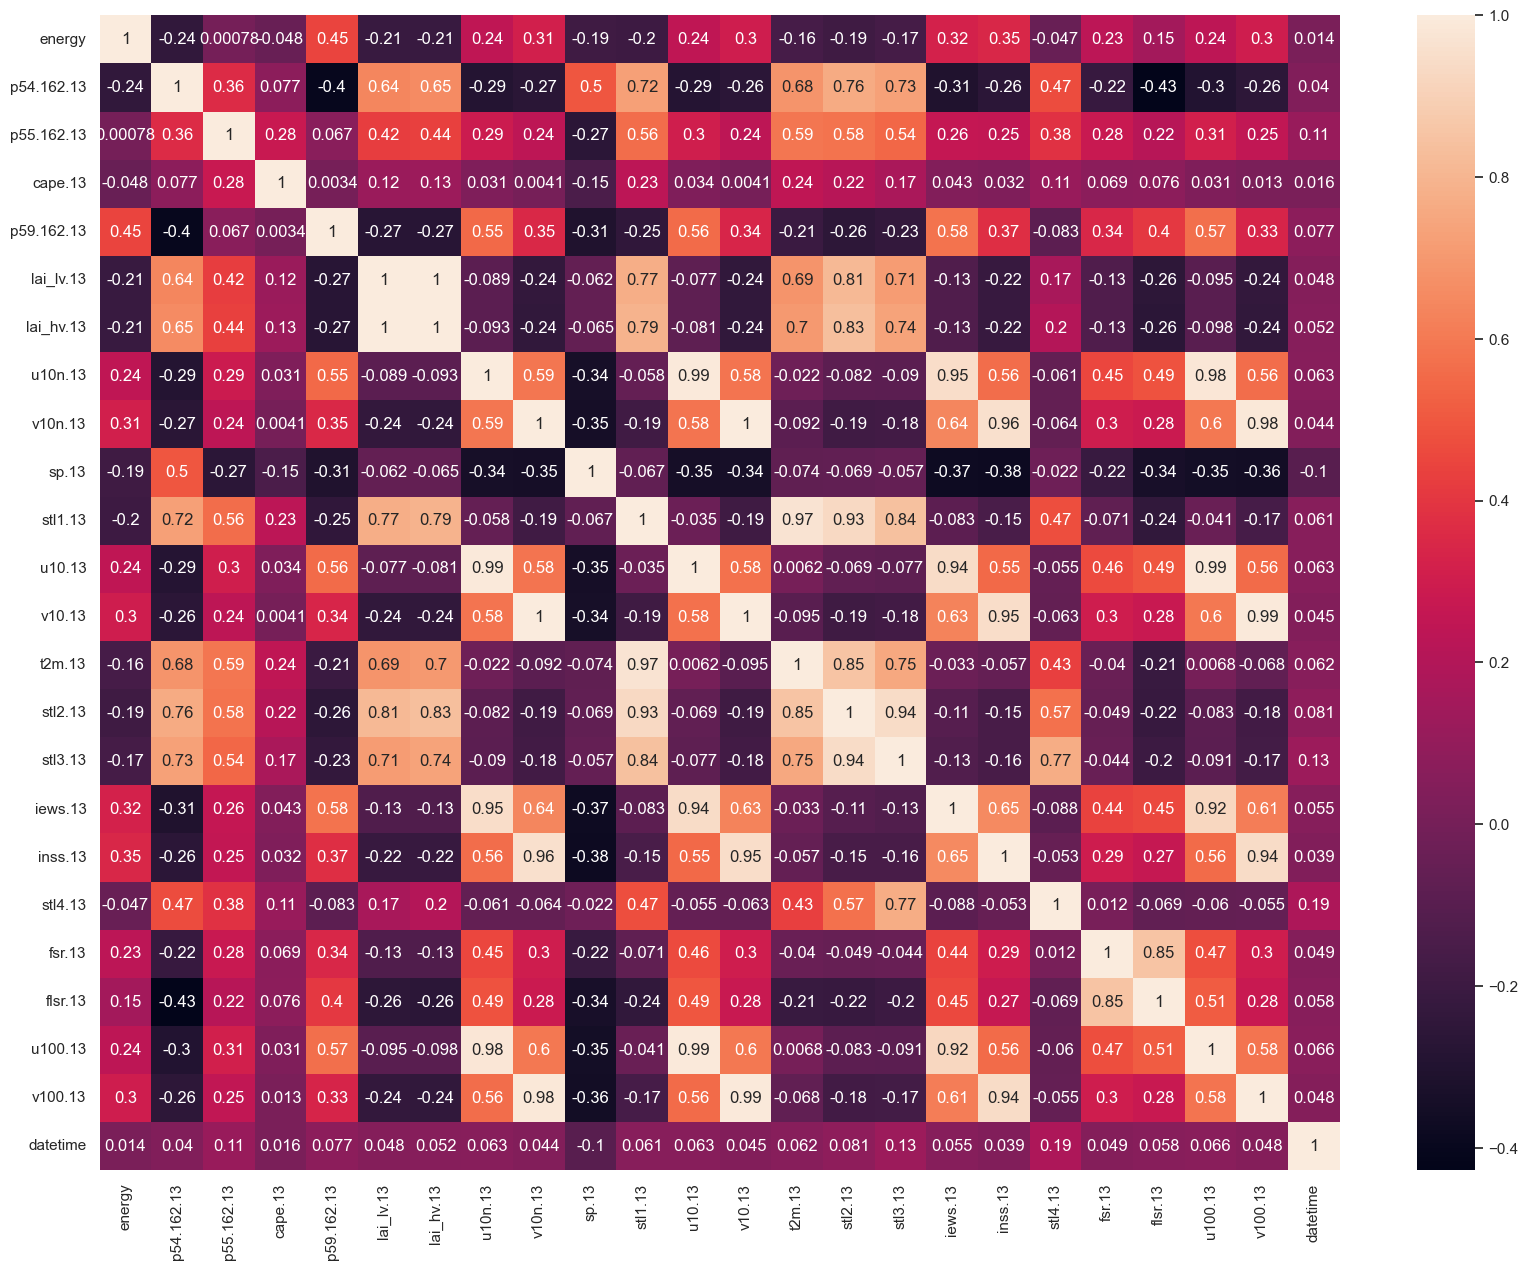

In [124]:
# Creamos la matriz de correlación
plt.figure(figsize=(20, 15))
copia = X_df.copy()
copia.insert(0, 'energy', wind_ava['energy'])
correlation_matrix = copia.corr()
sns.heatmap(data=correlation_matrix, annot=True)

Destaca la baja o nula correlación en la que oscila la variable `datetime` con todas las variables restantes de entrada y con la variable de salida. Lo que significa que dicha variable tiene un impacto poco significativo en la producción de la energía eólica.

En cuanto a la correlación negativa, ningún par de variables presentan dicha correlación, ya que ninguna rebaja el -0.4. Sin embargo, hay algunos pares de variables que muestran una alta correlación positiva. Y estos son los siguientes:
- u10 - u10n
- v10 - v10n
- lai_lv - lai_hv
- u10n - iews
- u100 - iews
- v100 - inss
- stl2 - stl3
- u100 - u10
- v100 - v10
- u100 - u10n
- v100 - v10n
- flsr - fsr
- lai_lv - stl2
- lai_hv - stl2

Mientras que entre las variables de entrada con la variable de salida (*energy*), no se aprecia una alta correlación.

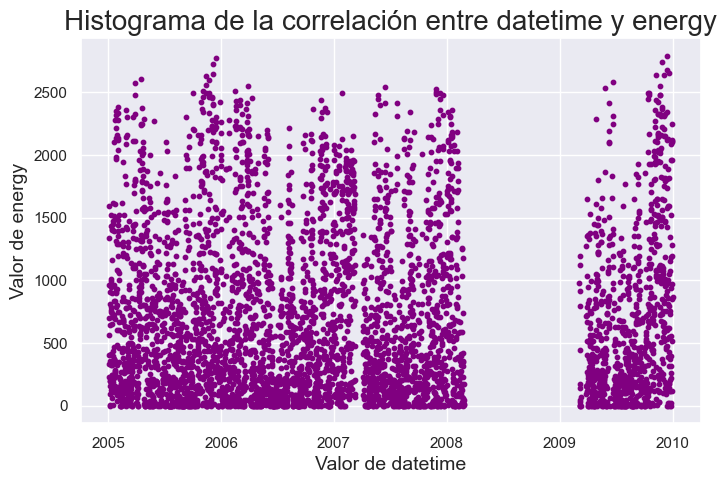

In [125]:
plt.figure(figsize=(8, 5))
plt.scatter(X_df['datetime'], y_df,  color='purple', marker='o', s=10)
plt.title('Histograma de la correlación entre datetime y energy', size=20)
plt.xlabel('Valor de datetime', size=14)
plt.ylabel('Valor de energy', size=14)
plt.grid(True)
plt.show()

Finalmente, como podemos observar, la correlación de estas dos variables es nula. Obtenemos una nube de puntos aleatorios que no siguen ninguna tendencia ni ningúna relación lineal. Por eso, se ha optado a eliminar dicha variable del *dataframe* de entrada ya que no tiene ningún impacto directo en la variable de salida. 

In [126]:
# Eliminar la variable datetime de X_df
X_df = X_df.drop(columns=['datetime'])
print(X_df.head())

     p54.162.13  p55.162.13    cape.13    p59.162.13  lai_lv.13  lai_hv.13  \
0  2.510824e+06    9.186295  13.527577  1.386937e+06   2.344111   2.432983   
1  2.513173e+06    8.849569   6.896412  1.153526e+06   2.343719   2.432838   
2  2.509627e+06    7.924080   4.774439  1.098754e+06   2.343300   2.432704   
3  2.510571e+06    6.922709   0.000000  1.076021e+06   2.342830   2.432514   
4  2.505664e+06    6.646282   0.000000  1.070830e+06   2.342437   2.432369   

    u10n.13   v10n.13         sp.13     stl1.13  ...      t2m.13     stl2.13  \
0 -0.757587 -1.922799  99846.319914  280.960661  ...  280.473098  281.042026   
1 -1.412620 -1.403011  99917.733093  279.296651  ...  278.286616  280.747406   
2 -2.290185 -0.754580  99764.378681  278.233956  ...  277.206490  280.114863   
3 -3.497855  1.271028  99672.670459  280.787263  ...  280.926600  279.991138   
4 -0.971249  0.553060  99372.811211  279.583112  ...  277.363875  280.576898   

      stl3.13   iews.13   inss.13     stl4.13    f

### Distribución de la variable de salida.

A continuación, vamos a analizar la distribución de la variable de salida, llamada *energy*.

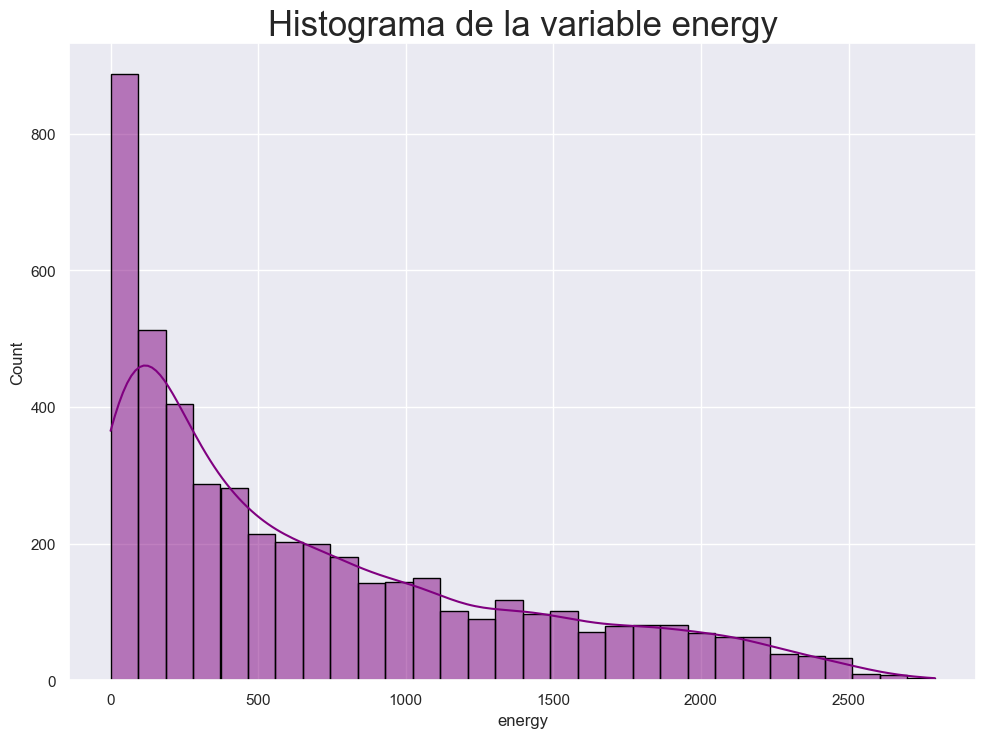

In [127]:
# Dibujamos el histograma de la variable de salida
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.histplot(y_df, bins=30, color='purple', kde=True, edgecolor='black')
plt.title('Histograma de la variable energy', size=25)
plt.show()

Obtenemes que la distribución de esta variable es exponencial, podemos apreciar una alta frecuencia de valores de baja energía, y una baja frecuencia de valores altos de energía.

---
## Evaluación outer.
---

En primer lugar, realizaremos la evaluación de diferentes modelos de regresión con sus hiperparámetros por defecto. 

### KNN.

En primer lugar, crearemos un modelo KNN sin escalar los datos y evaluaremos el rendimiento obtenido.

In [128]:
# Dividimos los datos entre entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=49)
# Creamos el modelo.
regr_knn = KNeighborsRegressor()
np.random.seed(49)
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn_o = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test)
# Evaluamos el rendimiento del modelo.
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn}")
print(f"R2: {r2_knn}")

RMSE: 636.3288087730467
R2: 0.06026198644919867


A continuación, escalaremos los datos aplicando diferentes métodos y evaluaremos cuál es el de mejor y más apropiado para este problema. 

- *StandardScaler*: escala los datos para que tengan una media de 0 y una desviación estándar de 1.

- *MinMaxScaler*: escala los datos al intervalo especificado (por defecto [0, 1]).

- *RobustScaler*: escala los datos utilizando estadísticas robustas para manejar valores atípicos.

- *MaxAbsScaler*: escala los datos dividiendo cada característica por su valor máximo absoluto.

- *QuantileTransformer*: transforma los datos para que tengan una distribución uniforme o gaussiana.

In [129]:
def escalado(scaler):
    model = KNeighborsRegressor()
    np.random.seed(49)
    X_train_result = scaler.fit_transform(X_train)
    X_test_result = scaler.transform(X_test)
    # Entrenamos el modelo.
    inicio = time.time()
    model.fit(X_train_result, y_train)
    fin = time.time()
    tiempo = fin - inicio
    # Realizamos las predicciones.
    y_test_pred = model.predict(X_test_result)
    # Evaluamos el rendimiento del modelo.
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    r2 = metrics.r2_score(y_test, y_test_pred)
    return rmse, r2, tiempo

In [130]:
# StandardScaler
scaler = StandardScaler()
rmse_standar, r2_standar, t_standar = escalado(scaler)
# MinMaxScaler
scaler = MinMaxScaler()
rmse_minmax, r2_minmax, t_minmax = escalado(scaler)
# RobustScaler
scaler = RobustScaler()
rmse_robust, r2_robust, t_robust = escalado(scaler)
# MaxAbsScaler
scaler = MaxAbsScaler()
rmse_maxabs, r2_maxabs, t_maxabs = escalado(scaler)
# QuantileTransformer
scaler = QuantileTransformer()
rmse_quantile, r2_quantile, t_quantile = escalado(scaler)

In [131]:
# Imprimimos en un dataframe todos los resultados.
resultados = pd.DataFrame({
    "RMSE": [rmse_knn, rmse_standar, rmse_minmax, rmse_robust, rmse_maxabs, rmse_quantile],
    "R2": [r2_knn, r2_standar, r2_minmax, r2_robust, r2_maxabs, r2_quantile],
    "Tiempo": [t_knn_o, t_standar, t_minmax, t_robust, t_maxabs, t_quantile]
}, index=["Sin escalar", "StandardScaler", "MinMaxScaler", "RobustScaler", "MaxAbsScaler", "QuantileTransformer"])
resultados


,RMSE,R2,Tiempo
Sin escalar,636.328809,0.060262,0.001264
StandardScaler,402.269009,0.624442,0.000508
MinMaxScaler,413.265640,0.603629,0.000311
RobustScaler,409.245852,0.611302,0.000388
MaxAbsScaler,406.858835,0.615823,0.000372
QuantileTransformer,421.414846,0.587842,0.000463


Finalmente obtenemos que el mejor modelo de KNN de regresión con escalado de datos es el *StandardScaler* debido a que es el que tiene el RMSE menor y el R2 más próximo a 1. Por lo tanto, este método es el que usaremos de aquí en adelante cuando sea necesario.

#### Escalado de los datos

Aplicaremos el método de escalado *StandardScaler*, debido a que es el de mejor resultado.

In [132]:
scaler = StandardScaler()
X_df_scaled = scaler.fit_transform(X_df)

#### División

Al tratarse de un problema de regresión, las métricas que se utilizarán para evaluar el rendimiento de cada modelo serán: RMSE (Error Cuadrático Medio) y R2 (Coeficiente de Determinación). Además dividiremos el conjunto de datos entre entrenamiento y test de esta forma: 2/3 y 1/3, respectivamente.

In [133]:
# Dividimos los datos entre entrenamiento y test.
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_df_scaled, y_df, test_size=0.33, random_state=49)

Volveremos a realizar el modelo KNN, pero esta vez utilizando los datos escalados y veremos si hay alguna mejora.

In [135]:
regr_knn = KNeighborsRegressor()
np.random.seed(49)
# Entrenamos el modelo.
inicio = time.time()
regr_knn.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_knn = fin - inicio
# Realizamos las predicciones.
y_test_pred = regr_knn.predict(X_test_scaled)
# Evaluamos el rendimiento del modelo.
rmse_knn_scaled = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_scaled = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_knn_scaled}")
print(f"R2: {r2_knn_scaled}")

RMSE: 402.54987543666596
R2: 0.623917593835212


Mejora significativamente la precisión de las predicciones. Y aumenta considerablemente la capacidad del modelo para explicar la variabilidad en los datos. Sin embargo, esta mejora significativa no significa que sea el mejor modelo final.

### Dummy.

Regresor simple y básico para problemas de regresión. Este modelo se tomará como referencia para detectar posibles mejoras en las predicciones.

In [136]:
# Crear el modelo Dummy.
regr_dummy = DummyRegressor(strategy="median")
np.random.seed(49)
# Entrenar el modelo.
inicio = time.time()
regr_dummy.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_dummy = fin - inicio
y_test_pred = regr_dummy.predict(X_test)
# Métricas de evaluación.
rmse_dummy = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_dummy = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_dummy}")
print(f"R2: {r2_dummy}")


RMSE: 692.091301457747
R2: -0.11165597168553609


Obtenemos que con este clasificador no existe casi ajuste ya que se aleja mucho de 1, el valor deseado para R2 (el coeficiente de determinación). Mientras que para el error cuadratico medio de la raiz, RMSE, nos indica que las predicciones se desvían mucho del valor real. 

Tras este análisis, podemo concluir que este modelo está realizando unas predicciones nada útiles y que es necesario otro modelo para conseguir unas predicciones más precisas.

### Regresión lineal.

Aplicaremos el modelo de regresión lineal ordinario. En este modelo, es beneficioso que los datos estén escalados.

In [137]:
regr_lineal = LinearRegression()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lineal}")
print(f"R2: {r2_lineal}")

RMSE: 539.7612031414392
R2: 0.32384392553387276


Obtenemos una leve mejora con respecto al modelo nulo (Dummy).

### Árbol de decisión.

A continuación evaluaremos el modelo de árbol de decisión y evaluaremos su rendimiento.

In [138]:
regr_tree = tree.DecisionTreeRegressor()
np.random.seed(49) 
# Entrenamos el modelo.
inicio = time.time()
regr_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_tree = fin - inicio
y_test_pred = regr_tree.predict(X_test)
# Métricas de evaluación.
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimir el resultado.
print(f"RMSE: {rmse_tree}")
print(f"R2: {r2_tree}")


RMSE: 509.8152113241104
R2: 0.3967890698918305


Tras la realización del modelo de regresión de árbol de decisión, podemos apreciar que mejora considerablemente con respecto al Dummy y muy poco con respecto al modelo lineal, en términos de precisión de predicción. Pero, sigue sin ser el mejor modelo ya que todavía existe un margen muy grande de mejora con predicciones más precisas.

### Árbol de decisión y regresión lineal.

Como algo adicional, evaluaremos este modelo. Se trata de un modelo de regresión que combina el árbol de decisión de regresión y la regresión lineal. Es decir, al modelo anteriormente analizado, le añadiremos como parámetro *base_estimator* (el tipo de regresor que va a utilizar en los nodos terminales), la regresión lineal básica.

In [139]:
regr_linear_tree = LinearTreeRegressor(base_estimator=LinearRegression())
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_linear_tree.fit(X_train, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_linear_tree = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_linear_tree.predict(X_test)
# Métricas de evaluación
rmse_linear_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_linear_tree = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_linear_tree}")
print(f"R2: {r2_linear_tree}")

RMSE: 383.13311481655455
R2: 0.6593228508176546


Con este modelo obtenemos unos mejores resultados. Obtenemos que este modelo es mejor para predcir los valores de la variable energía con precisión. Además, consigue con una mayor proporción, explicar la variabilidad de los valores de la variable de salida. Pero, obtenemos que el tiempo de ejecución es algo elevado.

### Regularización Ridge.

Analizaremos el modelo con regularización Ridge con valores por omisión. Es decir, sin ningún parámetro para evaluar su rendimiento.

In [140]:
regr_ridge = Ridge()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_ridge = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge}")
print(f"R2: {r2_ridge}")

RMSE: 540.1020237918318
R2: 0.322989767408254


### Regularización Lasso.

Ahora, analizaremos el modelo con regularización Lasso dado por omisión. Como en el modelo anterior, sin ningún hiperparámetro definido.

In [141]:
regr_lasso = Lasso()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_ridge.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento
t_lasso = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_ridge.predict(X_test_scaled)
# Métricas de evaluación
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_lasso}")
print(f"R2: {r2_lasso}")

RMSE: 540.1020237918318
R2: 0.322989767408254


### SVM Lineal.

In [142]:
regr_svm_lineal = SVR(kernel="linear")
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_svm_lineal.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_lineal = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_lineal.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_svm_lineal}")
print(f"R2 of the tree: {r2_svm_lineal}")

RMSE of the tree: 587.1540999280302
R2 of the tree: 0.199893462094492


### SVM Radial.

In [143]:
regr_svm_radial = SVR()
np.random.seed(49)
# Entrenamos el modelo
inicio = time.time()
regr_svm_radial.fit(X_train_scaled, y_train)
fin = time.time()
# Tiempo de entrenamiento.
t_svm_radial = fin - inicio
# Obtenemos las predicciones sobre el conjunto de prueba
y_test_pred = regr_svm_radial.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial}")
print(f"R2: {r2_svm_radial}")

RMSE: 632.1488676542411
R2: 0.07256741140669665


---
## Búsqueda de Hiperparámetros.
---

Para la evaluación *inner*, deberemos evaluar diferentes modelos ajustando hiperparámetros. Para ello consideraremos técnicas de validación cruzada, con el fin de determinar el modelo final, el mejor modelo según su rendimiento.

Se ha decidido que el parámetro `n_jobs` va a tomar el valor de -1 para que el sistema utilice todos los procesadores disponibles, consiguiendo una ejecución más rápida y eficiente. 

### KNN

In [144]:
# Search space with integer uniform distributions
param_grid = {'n_neighbors': list(range(2, 16, 2))
              }

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_knn_hpo = GridSearchCV(KNeighborsRegressor(),
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=inner,
                   n_jobs=-1, verbose=1)

np.random.seed(49)
inicio = time.time()
regr_knn_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_knn_hpo = fin - inicio

Fitting 3 folds for each of 7 candidates, totalling 21 fits


In [145]:
y_test_pred = regr_knn_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_knn_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_knn_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_knn_hpo}")
print(f"R2: {r2_knn_hpo}")
print(f"Mejor parámetro: {regr_knn_hpo.best_params_}")

RMSE: 397.2255086882668
R2: 0.6338003850207989
Mejor parámetro: {'n_neighbors': 8}


### Árbol de decisión.

Este modelo es el árbol de decisión de regresión utilizando *RandomizedSearchCV* con el hiperparámetro *n_iter* ajustado a 100.

In [146]:
# Search space with integer uniform distributions
param_grid = {'max_depth': sp_randint(2,16),
              'min_samples_split': sp_randint(2,16)}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

budget = 100
regr_tree_hpo = RandomizedSearchCV(tree.DecisionTreeRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(49)
inicio = time.time()
regr_tree_hpo.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo = fin - inicio

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [147]:
y_test_pred = regr_tree_hpo.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo}")
print(f"R2 of the tree: {r2_tree_hpo}")
print(f"Mejores parámetros: {regr_tree_hpo.best_params_}")

RMSE of the tree: 423.62431593913664
R2 of the tree: 0.5835092267162383
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 4}


Haremos el modelo con el *BayesSearchCV* para ver si mejora el rendimiento en comparación con el anterior. A continuación, ajustando los hiperparámetros, obtenemos los siguientes resultados.

In [149]:
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import KFold
np.int = int

# Search space with integer uniform distributions
param_grid = {'max_depth': Integer(2,20),
              'min_samples_split': Integer(20,100)}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

# Cambiamos otra vez el budget y el tipo de busqueda
budget = 70
regr_tree_hpo_bayes = BayesSearchCV(tree.DecisionTreeRegressor(),
                    param_grid,
                    scoring='neg_mean_squared_error',
                    cv=inner,
                    n_jobs=-1, verbose=0,
                    n_iter=budget
                    )

np.random.seed(49)
inicio = time.time()
regr_tree_hpo_bayes.fit(X=X_train, y=y_train)
fin = time.time()
t_tree_hpo_bayes = fin - inicio

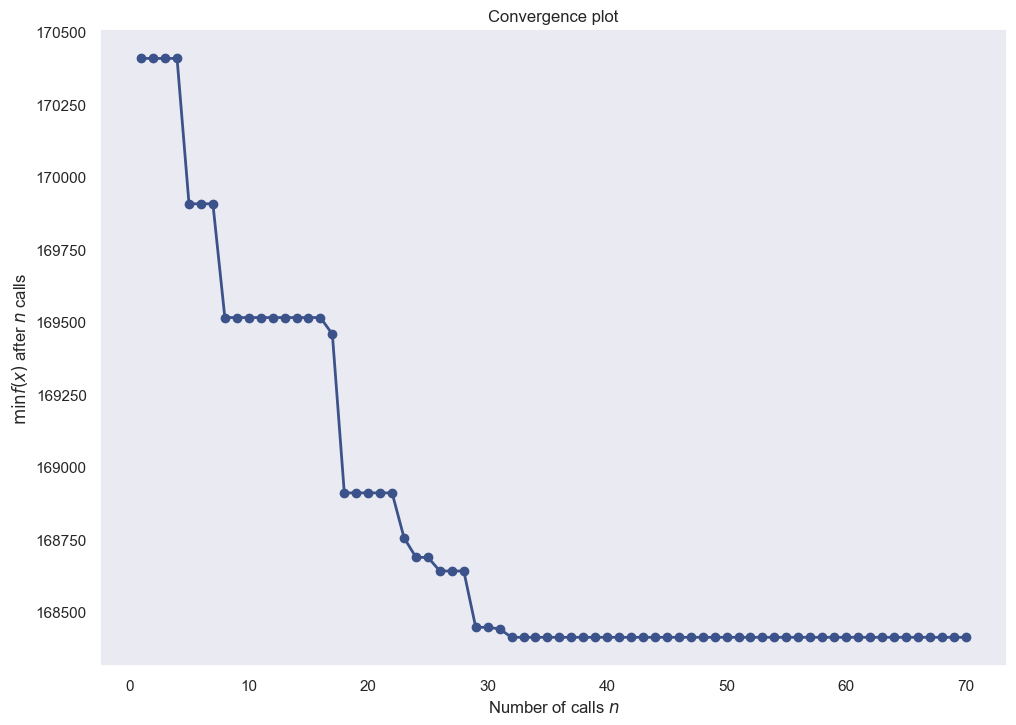

In [150]:
from skopt.plots import plot_objective, plot_histogram, plot_convergence
# Comprobar si la optimización ha convergido
_ = plot_convergence(regr_tree_hpo_bayes.optimizer_results_[0])
plt.show()

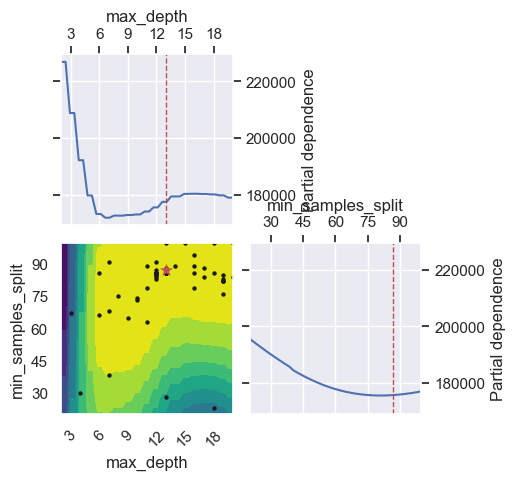

<Figure size 4000x1500 with 0 Axes>

In [151]:
# Visualizar la función objetivo
_ = plot_objective(regr_tree_hpo_bayes.optimizer_results_[0],
                   dimensions=['max_depth', 'min_samples_split'],
                   n_minimum_search=int(1e8))
plt.figure(figsize=(40, 15)) 
plt.show()

In [152]:
y_test_pred = regr_tree_hpo_bayes.predict(X_test)
# Métricas de evaluación
rmse_tree_hpo_bayes = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree_hpo_bayes = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE of the tree: {rmse_tree_hpo_bayes}")
print(f"R2 of the tree: {r2_tree_hpo_bayes}")
print(f"Mejores parámetros: {regr_tree_hpo_bayes.best_params_}")

RMSE of the tree: 424.64536220927556
R2 of the tree: 0.5814991020631398
Mejores parámetros: OrderedDict([('max_depth', 13), ('min_samples_split', 87)])


Como podemos ver, el rendimiento con este modelo tampoco mejora mucho. Podríamos aumentar el número de iteraciones que realizará la busqueda de hiperparámetros e intentar conseguir que mejore el rendimiento del modelo. Sin embargo, como podemos ver en la gráfica de convergencia,  el valor de la métrica tras cierto número de iteraciones muestra poco cambio. Por este motivo, esta idea se descarta, ya que no obtenedremos beneficios significatos. Además, otro motivo también es por el tiempo de ejecución, que aumentaría innecesariamente.

### Regularización Ridge.

Ahora pasaremos a evaluar el rendimiento del modelo con regularización Ridge. Esta técnica utiliza el parametro *alpha* para imponer una penalización en los coeficientes del modelo. 

In [153]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_ridge_hpo = GridSearchCV(Ridge(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_ridge_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_ridge_hpo = fin - inicio

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [154]:
y_test_pred = regr_ridge_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_ridge_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_ridge_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_ridge_hpo}")
print(f"R2: {r2_ridge_hpo}")
print(f"Mejor parámetro: {regr_ridge_hpo.best_params_}")

RMSE: 539.8418388606162
R2: 0.32364188654474646
Mejor parámetro: {'alpha': 0.3}


### Regularización Lasso.

Por otro lado, evaluaremos el modelo de regresión lineal con regularización Lasso. Al igual que Ridge, también se trata de una técnica que impone una penalización en los coeficientes del modelo, con una pequeña diferencia del anterior, que puede forza a que algunos coeficientes sean cero.

In [187]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

preprocessor = StandardScaler()
pipe_regrLasso = Pipeline([
        ('preproceso', preprocessor),
        ('regresor', LassoCV(
            alphas          = [0, 0.1, 0.2, 0.3, 0.4, 0.5],
            cv              = 3,
            max_iter        = 10000
         ))
])

np.random.seed(49)
inicio = time.time()
pipe_regrLasso.fit(X = X_train_scaled, y = y_train)
fin = time.time()
t_lasso_hpo = fin - inicio

In [188]:
y_test_pred = pipe_regrLasso.predict(X=X_test_scaled)

rmse_lasso_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_lasso_hpo = metrics.r2_score(y_test, y_test_pred)

print(f"RMSE de regresión lineal Lasso: {rmse_lasso_hpo}")
print(f"R2 de regresión lineal Lasso: {r2_lasso_hpo}")
print(f"Mejor aplpha: {pipe_regrLasso['regresor'].alpha_}")

RMSE de regresión lineal Lasso: 539.7612011673475
R2 de regresión lineal Lasso: 0.32384393047974147
Mejor aplpha: 0.0


Al realizar la regularización Lasso obtenemos que el mejor parámetro para alpha es 0. Esto significa que es mejor utilizar un modelo estándar de regresión lineal sin regularización Lasso.

### Elastic Net

In [171]:
from sklearn.linear_model import ElasticNet

param_grid = {'alpha': [0.0001, 0.001, 0.005, 0.01],
              'l1_ratio':  [0.1, 0.3, 0.5, 0.7, 0.9]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_elastic_hpo = GridSearchCV(ElasticNet(max_iter=100000),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_elastic_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_elastic_hpo = fin - inicio

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [172]:
y_test_pred = regr_elastic_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_elastic_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_elastic_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_elastic_hpo}")
print(f"R2: {r2_elastic_hpo}")
print(f"Mejor parámetro: {regr_elastic_hpo.best_params_}")

RMSE: 539.8480295260512
R2: 0.3236263741094326
Mejor parámetro: {'alpha': 0.001, 'l1_ratio': 0.9}


En conclusión, estos tres últimos modelos de regrsión lineal con regularizaciones obtienen resultados muy similares en cuanto al rendimiento, aproximadamente un RMSE de 539. Lo que significa que los tres proporcionan la misma, o muy parecida, capacidad de predicción para nuestro conjunto de datos. Al tratarse de un conjunto de datos bastante grande y la relación entre las variables con la objetivo es no lineal, los modelos lineales no son los más adecuados para tratar dichos problemas de manera efectiva.

### SVM lineal

Como siguiente modelo a evaluar se trata del SVM lineal, con el kernel especificado a lineal. Tras el ajuste de su hiperparámetro, hemos obtenido lo siguiente.

In [173]:
param_grid = {'C': [5000, 10000, 15000, 20000]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_lineal_hpo = GridSearchCV(SVR(kernel="linear"),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_lineal_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_lineal_hpo = fin - inicio

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [174]:
y_test_pred = regr_svm_lineal_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_lineal_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_lineal_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_lineal_hpo}")
print(f"R2: {r2_svm_lineal_hpo}")
print(f"Mejor parámetro: {regr_svm_lineal_hpo.best_params_}")

RMSE: 572.5173070770371
R2: 0.23928695583648896
Mejor parámetro: {'C': 10000}


### SVM Radial

El siguiente modelo a evaluar, va a ser el mismo que el anterior, pero el radial. Es decir, el kernel dado por omisión, el radial. Tras el ajuste de hiperparámetros, obtenemos lo siguiente.

In [175]:
param_grid = {'C': [30000, 30500, 40000],
              'gamma': [0.005, 0.01, 0.05]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regr_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
inicio = time.time()
regr_svm_radial_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_svm_radial_hpo = fin - inicio

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [176]:
y_test_pred = regr_svm_radial_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_svm_radial_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_svm_radial_hpo}")
print(f"R2: {r2_svm_radial_hpo}")
print(f"Mejor parámetro: {regr_svm_radial_hpo.best_params_}")

RMSE: 360.1636294797408
R2: 0.698946741654539
Mejor parámetro: {'C': 30000, 'gamma': 0.01}


Con este modelo, tras el proceso de ajustar ambos parámetros, obtenemos que una notable mejora en la predicción. Tras la evaluación del modelo, podemos ver como se reduce bastante el valor del RMSE y como aumenta en gran medida el R2, respecto al modelo dummy, al SVM radial con los datos por omisión y al SVM lineal por ajuste de hiperparámetros.

### Random Forest.

A continuación, vamos a utilizar este algoritmo de aprendizaje automático utilizado frecuentemente y a ajustar sus hiperparámetros, para ver si obtenemos un mejor rendimiento.

In [184]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': sp_randint(50, 200),
              'max_features': sp_randint(1, X_df.shape[1]),
              'max_depth': sp_randint(2, 20),
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(1, 20)}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

budget = 100
regr_rf_hpo = RandomizedSearchCV(RandomForestRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         refit=True,
                         n_jobs=-1, verbose=1,
                         n_iter = budget
                        )

np.random.seed(49)
inicio = time.time()
regr_rf_hpo.fit(X=X_train_scaled, y=y_train)
fin = time.time()
t_rf_hpo = fin - inicio

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [185]:
y_test_pred = regr_rf_hpo.predict(X_test_scaled)
# Métricas de evaluación
rmse_rf_hpo = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_rf_hpo = metrics.r2_score(y_test, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmse_rf_hpo}")
print(f"R2: {r2_rf_hpo}")
print(f"Mejor parámetro: {regr_rf_hpo.best_params_}")

RMSE: 365.8523417266806
R2: 0.6893614845913147
Mejor parámetro: {'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 130}


Con este modelo es cierto que se obtiene unos resultados muy buenos en cuanto al RMSE y al R2, pero comparado con el SVM radial, no son los mejores.

---
## Tiempos de entrenamiento
---

Para finalizar la evaluación *outer*, veremos los tiempos de entrenamiento obtenidos. Expondremos y analizaremos los tiempos de ejecución junto a los resultados obtenidos de cada modelo para evaluar el rendimiento de cada uno de ellos. Con el fin principal de obtener el modelo final que resuelva este problema de regresión.

In [186]:
# Tomaremos como referencia el modelo Dummy.
tabla_dummy = pd.DataFrame({
    "Modelo": ["Dummy"],
    "RMSE": [rmse_dummy],
    "R2": [r2_dummy],
    "Tiempo": [t_dummy]
})
tabla_dummy

,Modelo,RMSE,R2,Tiempo
0,Dummy,692.091301,-0.111656,0.000657


In [189]:
# Resultado de los modelos sin HPO.
tabla_sin_hpo = pd.DataFrame({
    "RMSE": [rmse_knn_scaled, rmse_lineal, rmse_tree, rmse_linear_tree, rmse_ridge, rmse_lasso, rmse_svm_lineal, rmse_svm_radial],
    "R2": [r2_knn_scaled, r2_lineal, r2_tree, r2_linear_tree, r2_ridge, r2_lasso, r2_svm_lineal, r2_svm_radial],
    "Tiempo": [t_knn, t_lineal, t_tree, t_linear_tree, t_ridge, t_lasso, t_svm_lineal, t_svm_radial]
}, index = ["KNN", "Regresión lineal", "Árbol de decisión", "Árbol con regresión lineal", "Regularización ridge", "Regularización lasso", "SVM lineal", "SVM radial"])

In [193]:
# Resultados de los modelos con HPO.
tabla_hpo = pd.DataFrame({
    "RMSE HPO": [rmse_knn_hpo, rmse_tree_hpo, rmse_tree_hpo_bayes, rmse_ridge_hpo, rmse_lasso_hpo, rmse_elastic_hpo, rmse_svm_lineal_hpo, rmse_svm_radial_hpo, rmse_rf_hpo],
    "R2 HPO": [r2_knn_hpo, r2_tree_hpo, r2_tree_hpo_bayes, r2_ridge_hpo, r2_lasso_hpo, r2_elastic_hpo, r2_svm_lineal_hpo, r2_svm_radial_hpo, r2_rf_hpo],
    "Tiempo HPO": [t_knn_hpo, t_tree_hpo, t_tree_hpo_bayes, t_ridge_hpo, t_lasso_hpo, t_elastic_hpo, t_svm_lineal_hpo, t_svm_radial_hpo, t_rf_hpo]
}, index = ["KNN", "Árbol de decisión", "Árbol de decisión Bayes", "Regularización ridge", "Regularización lasso", "Elastic net", "SVM lineal", "SVM radial", "Random forest"])

Unificaremos las tablas en una sola para ver mejor los resultados. A la izquierda quedan los resultados sin ajuste de hiperparámetros y a la derecha los ajustados. Adicionalmente, con fines simplemente visuales, se ha decidido eliminar los *NaN* y sustituirlos por guiones.

In [194]:
# Unificamos ambas tablas en una sola.
tabla = pd.concat([tabla_sin_hpo, tabla_hpo], axis=1)
tabla = tabla.fillna('-')
tabla

,RMSE,R2,Tiempo,RMSE HPO,R2 HPO,Tiempo HPO
KNN,402.549875,0.623918,0.000678,397.225509,0.6338,2.118229
Regresión lineal,539.761203,0.323844,0.016957,-,-,-
Árbol de decisión,509.815211,0.396789,0.114724,423.624316,0.583509,2.76689
Árbol con regresión lineal,383.133115,0.659323,187.642855,-,-,-
Regularización ridge,540.102024,0.32299,0.003678,539.841839,0.323642,1.472757
Regularización lasso,540.102024,0.32299,0.001847,539.761201,0.323844,2.2129
SVM lineal,587.1541,0.199893,0.326723,572.517307,0.239287,40.860666
SVM radial,632.148868,0.072567,0.369727,360.163629,0.698947,22.373781
Árbol de decisión Bayes,-,-,-,424.645362,0.581499,148.307971
Elastic net,-,-,-,539.84803,0.323626,5.869658


Para visualizar mejor estos resultados, los expondremos en la gráfica siguiente en relación tiempo de entrenamiento y rendimiento.

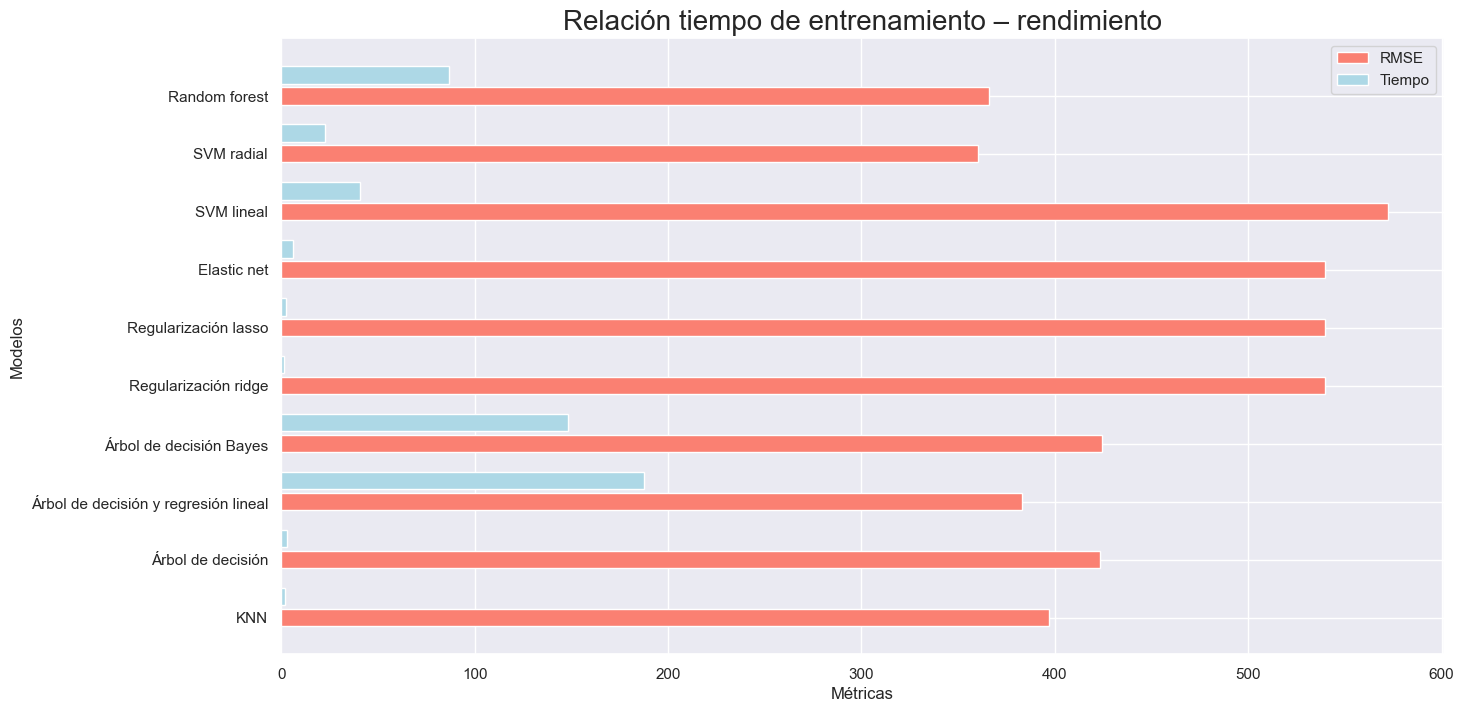

In [210]:
modelos = ["KNN", "Árbol de decisión", "Árbol de decisión y regresión lineal", "Árbol de decisión Bayes", "Regularización ridge", "Regularización lasso", "Elastic net", "SVM lineal", "SVM radial", "Random forest"]
rmse = [rmse_knn_hpo, rmse_tree_hpo, rmse_linear_tree, rmse_tree_hpo_bayes, rmse_ridge_hpo, rmse_lasso_hpo, rmse_elastic_hpo, rmse_svm_lineal_hpo, rmse_svm_radial_hpo, rmse_rf_hpo]
tiempos = [t_knn_hpo, t_tree_hpo, t_linear_tree, t_tree_hpo_bayes, t_ridge_hpo, t_lasso_hpo, t_elastic_hpo, t_svm_lineal_hpo, t_svm_radial_hpo, t_rf_hpo]

posiciones = np.arange(len(modelos))
ancho = 0.3
plt.figure(figsize=(15, 8))
plt.barh(posiciones, rmse, ancho, label='RMSE', color='salmon')
plt.barh(posiciones + 1.2*ancho, tiempos, ancho, label='Tiempo', color='lightblue')
plt.yticks(posiciones + ancho, modelos)
plt.yticks(posiciones, modelos)
plt.xlabel('Métricas')
plt.ylabel('Modelos')
plt.title('Relación tiempo de entrenamiento – rendimiento', size=20)
plt.legend()
plt.show()


---
## Modelo final.
---

Para realizar el modelo final de este caso práctico de predicción, la mejor alternativa que hemos obtenido es el modelo SVM radial.

In [211]:
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")
# Separación de variables de entrada y de salida.
X_final = wind_ava.filter(regex='.13$')
y_final = wind_ava['energy']

In [212]:
# Escalar los datos
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

In [213]:
# División de los datos en entrenamiento y test.
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final_scaled, y_final, test_size=0.33, random_state=49)

In [214]:
# Creamos el modelo final
regr_final = regr_svm_radial_hpo
# Con los mejores parámetros obtenidos
best_params = regr_svm_radial_hpo.best_params_
regr_final = SVR(**best_params)
# Entrenamos el modelo final
regr_final.fit(X_train_final, y_train_final)

SVR(C=30000, gamma=0.01)

In [215]:
# Realizamos las predicciones
y_test_pred = regr_final.predict(X_test_final)
# Evaluamos el rendimiento del modelo
rmse_final = np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred))
r2_final = metrics.r2_score(y_test_final, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_final}")
print(f"R2 del modelo final: {r2_final}")

RMSE del modelo final: 360.1636294797408
R2 del modelo final: 0.698946741654539


Para entregar el modelo final. Entrenamos con todos los datos.

In [216]:
regr_final.fit(X_final_scaled, y_final)

SVR(C=30000, gamma=0.01)

In [217]:
# Guardarlo en un fichero.
import pickle
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(regr_final, file)

A continuación, utilizaremos el modelo final para realizar predicciones para el conjunto de datos del problema.

In [218]:
wind_comp = pd.read_csv('wind_comp.csv.gz', compression="gzip")
# Separación de variables de entrada y de salida.
X_comp = wind_comp.filter(regex='.13$')

In [219]:
# Escalar los datos.
X_comp_scaled = scaler.fit_transform(X_comp)

In [220]:
# Realizamos las predicciones
y_test_pred = regr_final.predict(X_comp_scaled)

In [221]:
# Guardar el modelo en un fichero csv.
import csv
with open('predicciones.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(["predicciones"])
    for pred in y_test_pred:
        writer.writerow([pred])

In [222]:
# Variable de salida
y_comp = wind_comp['energy']
# Evaluamos el rendimiento del modelo
rmse_final = np.sqrt(metrics.mean_squared_error(y_comp, y_test_pred))
r2_final = metrics.r2_score(y_comp, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_final}")
print(f"R2 del modelo final: {r2_final}")

RMSE del modelo final: 397.3396387785031
R2 del modelo final: 0.683540188557521


Es decir, obtenemos que nuestro modelo final comete de media ese error. Es decir, que en las prediccione del modelo, de media, están a una distancia de aproximadamente 397 unidades de la variable objetivo. Por otro lado, el coeficiente de determinación nos indica que aproximadamente el 68% de la variabilidad de la variable objetivo es explicada por nuestro modelo final.

**Random Forest**

A continuación, se incluye otra alternativa para el modelo final, *Random Forest*.

In [226]:
# Creamos el modelo final
regr_otro = regr_rf_hpo
# Con los mejores parámetros obtenidos
best_params = regr_rf_hpo.best_params_
regr_otro = RandomForestRegressor(**best_params)
# Entrenamos el modelo final
regr_otro.fit(X_train_final, y_train_final)

RandomForestRegressor(max_depth=15, max_features=7, min_samples_leaf=2,
                      min_samples_split=11, n_estimators=130)

In [227]:
# Realizamos las predicciones
y_test_pred = regr_otro.predict(X_test_final)
# Evaluamos el rendimiento del modelo
rmse_otro = np.sqrt(metrics.mean_squared_error(y_test_final, y_test_pred))
r2_otro = metrics.r2_score(y_test_final, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_otro}")
print(f"R2 del modelo final: {r2_otro}")

RMSE del modelo final: 366.67931587720096
R2 del modelo final: 0.687955560229474


In [228]:
regr_otro.fit(X_final_scaled, y_final)

RandomForestRegressor(max_depth=15, max_features=7, min_samples_leaf=2,
                      min_samples_split=11, n_estimators=130)

In [229]:
# Realizamos las predicciones
y_test_pred = regr_otro.predict(X_comp_scaled)

In [230]:
# Evaluamos el rendimiento del modelo
rmse_otro = np.sqrt(metrics.mean_squared_error(y_comp, y_test_pred))
r2_otro = metrics.r2_score(y_comp, y_test_pred)
# Imprimimos el resultado
print(f"RMSE del modelo final: {rmse_otro}")
print(f"R2 del modelo final: {r2_otro}")

RMSE del modelo final: 396.73660074507956
R2 del modelo final: 0.6845000348345778


Es cierto que con este modelo, se obtiene unos valores más precisos, pero como no son muy significativos, hemos decidido dejar el *SVM radial* como modelo final.

---
## Converisón a un problema de clasificación.
---

En la siguiente sección, convertiremos el problema de regresión en uno de clasificación. Esto lo haremos de la siguiente manera: cuando la energía sea menor que el tercer cuantil, se considerará clase “baja”, y cuando sea mayor, clase “alta”.

In [231]:
df = wind_ava.filter(regex='.13$').copy()
df['energy'] = wind_ava['energy'].copy()

In [232]:
# Calcular el tercer cuartil de la variable 'energy'
tercer_cuartil = df['energy'].quantile(0.75)

In [233]:
# Filtrar los datos donde 'energy' sea menor o igual al tercer cuartil (energia_baja)
energia_baja = df[df['energy'] <= tercer_cuartil]
energia_baja.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,energy
0,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,280.960661,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,402.71
1,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,279.296651,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,696.80
4,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,279.583112,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,562.50
5,2.505768e+06,6.125948,0.000000,1.094100e+06,2.342045,2.432235,-0.153568,1.554043,99257.763690,276.620140,...,279.654761,281.464691,0.003361,0.144389,284.603425,0.404758,-5.957546,0.190590,5.349629,232.30
6,2.503477e+06,7.038564,0.000000,1.264504e+06,2.341653,2.432090,1.247802,1.676775,99277.551356,276.140000,...,278.712132,281.416011,0.115504,0.144389,284.585652,0.406001,-5.957198,4.105168,4.612229,329.95


In [234]:
# Filtrar los datos donde 'energy' sea mayor que el tercer cuartil (energia_alta)
energia_alta = df[df['energy'] > tercer_cuartil]
energia_alta.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,energy
2,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,278.233956,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,1591.15
3,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,280.787263,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,1338.62
19,2.501566e+06,5.069699,0.000000,2.231439e+06,2.335507,2.429933,2.058460,4.320565,98937.989932,277.694496,...,279.689559,281.227375,0.296734,0.562065,284.334515,0.408046,-6.009090,3.930966,8.244346,1524.05
27,2.490700e+06,6.122561,0.000000,1.121844e+06,2.332212,2.428771,1.433000,4.239903,98552.257286,278.051432,...,280.170539,281.192801,0.215333,0.535969,284.205662,0.408767,-6.000770,3.114884,8.642482,1434.55
32,2.489981e+06,19.044174,0.000000,9.698767e+05,2.330119,2.428012,0.958361,5.837511,98741.381710,279.586661,...,280.399430,281.176482,0.227068,0.739084,284.127423,0.422033,-5.820874,2.386688,9.411813,1164.17


### Energía baja.

En primer lugar, por un lado se tratará el problema de regresión para valores bajos de energía.

In [235]:
X_baja = energia_baja.drop(columns='energy')
y_baja = energia_baja['energy']

In [236]:
# Escalar
scaler = StandardScaler()
X_baja_scaled = scaler.fit_transform(X_baja)

# Dividir los datos en entrenamiento y test
X_train_baja, X_test_baja, y_train_baja, y_test_baja = train_test_split(X_baja_scaled, y_baja, test_size=0.33, random_state=49)


A continuación, se lleva a cabo el proceso de búsqueda y ajuste de hiperparámetros para el modelo SVM con kernel radial utilizando la técnica de validación cruzada. Durante la búsqueda, se va a utilizar la métrica de RMSE para evaluar el rendimiento y el R2. 

In [243]:
param_grid = {'C': [3000, 4000, 5000, 6000, 7000, 8000],
              'gamma': [0.001, 0.005, 0.01, 0.05, 0.1]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regrBaja_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
regrBaja_svm_radial_hpo.fit(X=X_train_baja, y=y_train_baja)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [3000, 4000, 5000, 6000, 7000, 8000],
                         'gamma': [0.001, 0.005, 0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error', verbose=1)

In [244]:
y_test_pred = regrBaja_svm_radial_hpo.predict(X_test_baja)
# Métricas de evaluación
rmseBaja_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test_baja, y_test_pred))
r2Baja_svm_radial_hpo = metrics.r2_score(y_test_baja, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmseBaja_svm_radial_hpo}")
print(f"R2: {r2Baja_svm_radial_hpo}")
print(f"Mejor parámetro: {regrBaja_svm_radial_hpo.best_params_}")

RMSE: 242.45095959401831
R2: 0.4185306563704383
Mejor parámetro: {'C': 6000, 'gamma': 0.01}


### Energia alta.

En segundo lugar, se va a realizar lo msimo que lo anterior pero para valores altos de energía. 

In [239]:
X_alta = energia_alta.drop(columns='energy')
y_alta = energia_alta['energy']

In [240]:
# Escalar
scaler = StandardScaler()
X_alta_scaled = scaler.fit_transform(X_alta)

# Dividir los datos en entrenamiento y test
X_train_alta, X_test_alta, y_train_alta, y_test_alta = train_test_split(X_alta_scaled, y_alta, test_size=0.33, random_state=49)


Al igual que el anterior, a continuación, se realiza el mismo proceso de busqueda y ajustes de hiperparámetros del modelo SVM radial, pero con el subconjunto de datos que representan valores altos de energía. Para ello, se van a utilizar las mismas métricas que en el caso anterior. 

In [246]:
param_grid = {'C': [3000, 4000, 5000, 6000, 7000, 8000],
              'gamma': [0.001, 0.005, 0.01, 0.05]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

regrAlta_svm_radial_hpo = GridSearchCV(SVR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         n_jobs=-1, verbose=1
                        )

np.random.seed(49)
regrAlta_svm_radial_hpo.fit(X=X_train_alta, y=y_train_alta)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [3000, 4000, 5000, 6000, 7000, 8000],
                         'gamma': [0.001, 0.005, 0.01, 0.05]},
             scoring='neg_mean_squared_error', verbose=1)

In [247]:
y_test_pred = regrAlta_svm_radial_hpo.predict(X_test_alta)

# Métricas de evaluación
rmseAlta_svm_radial_hpo = np.sqrt(metrics.mean_squared_error(y_test_alta, y_test_pred))
r2Alta_svm_radial_hpo = metrics.r2_score(y_test_alta, y_test_pred)

# Imprimimos resultados
print(f"RMSE: {rmseAlta_svm_radial_hpo}")
print(f"R2: {r2Alta_svm_radial_hpo}")
print(f"Mejor parámetro: {regrAlta_svm_radial_hpo.best_params_}")

RMSE: 342.7016061967315
R2: 0.2700801532263487
Mejor parámetro: {'C': 6000, 'gamma': 0.01}


### Conclusiones.

Al comparar los resultados de cada subconjunto de energía, se observan diferencias significativas en el rendimiento de las predicciones. Para el subconjunto de baja energía, el modelo muestra un RMSE de aproximadamente 242 y un R2 de un 41.8%, lo que indica un buen ajuste del modelo. Mientras que, para el subconjunto de alta energía, los valores obtenidos son un RMSE de aproximadamente 342 y un R2 de un 27%, lo que indica que tiene un rendimiento inferior en las predicciones. Por otro lado, los mejores parámetros encontrados para ambos subconjuntos son los mimso o muy parecidos. Además, esto también se ve reflejado en la distribución de la variable de salida del EDA, donde se vé claramente una mayor concentración de datos bajos de energía en comparación con los altos.

### Resolución.

A continuación, se va a realizar la resolución del problema de clasificación. Para ello, se va a utilizar diferentes modelos y los vamos a ajustar para obtener el mejor rendimiento posible.

In [251]:
energia_baja['energy'] = 0
energia_alta['energy'] = 1

# Unimos los dos conjuntos de datos
df_clf = pd.concat([energia_baja, energia_alta])

# Imprimir las primeras filas
df_clf.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,energy
0,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,280.960661,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,0
1,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,279.296651,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,0
4,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,279.583112,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,0
5,2.505768e+06,6.125948,0.000000,1.094100e+06,2.342045,2.432235,-0.153568,1.554043,99257.763690,276.620140,...,279.654761,281.464691,0.003361,0.144389,284.603425,0.404758,-5.957546,0.190590,5.349629,0
6,2.503477e+06,7.038564,0.000000,1.264504e+06,2.341653,2.432090,1.247802,1.676775,99277.551356,276.140000,...,278.712132,281.416011,0.115504,0.144389,284.585652,0.406001,-5.957198,4.105168,4.612229,0


In [252]:
# Dividimos entre variables de entrada y de salida
X_clf = df_clf.drop(columns='energy')
y_clf = df_clf['energy']

In [253]:
# Dividimos los datos en entrenamiento y test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.33, random_state=49)

#### Logistic Regression.

En primer lugar, se va a utilizar este modelo. Para ello, se va a escalar los datos con *StandarScaler*. Por otro lado, para la búsqueda de hiperparámetros se va a utilizar la validación cruzada. Con el objetivo principal de encontrar los mejores hiperparámetros que mejores la precisión del modelo en la clasificación de los datos.

In [278]:
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()       # escalar
lr = LogisticRegression(penalty='none', max_iter=10000, random_state = 49)      # modelo

pipe_scale_lr = Pipeline([
    ('scale', scaler),
    ('lr', lr)])

In [279]:
param_grid = [{'lr__penalty': ['l1', 'l2', 'elascticnet'],
               'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

inner = KFold(n_splits=3, shuffle=True, random_state=42)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_lr = GridSearchCV (estimator  = pipe_scale_lr,
                    param_grid = param_grid,
                    scoring='accuracy', #OJO!!! scoring=‘balanced_accuracy’
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(42)

clf_lr.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=49))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'lr__penalty': ['l1', 'l2', 'elascticnet'],
                          'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                         'sag', 'saga']}],
             return_train_score=True, scoring='accuracy', verbose=1)

Continuaremos analizando los resultados obtenidos en la búsqueda de hiperparámetros realizada mediante la validación cruzada. 

In [280]:
resultados = pd.DataFrame(clf_lr.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_lr__C,param_lr__penalty,param_lr__solver,mean_test_score,std_test_score,mean_train_score,std_train_score
52,1,l2,liblinear,0.817668,0.002886,0.820183,0.002406
51,1,l2,lbfgs,0.817353,0.003185,0.820340,0.002628
54,1,l2,saga,0.817353,0.003185,0.820654,0.002406
53,1,l2,sag,0.817353,0.003185,0.820654,0.002406
50,1,l2,newton-cg,0.817353,0.003185,0.820497,0.002524


In [281]:
clf_lr.best_params_, clf_lr.best_score_

({'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'},
 0.817667858137867)

Obtenemos que la mejor combinación de parámetros que obtiene la puntuación media más alta en la validación cruzada es: 
- C igual a 1
- penalty igual a l2
- solver igual a liblinear

In [282]:
clf_lr_final = clf_lr.best_estimator_
print("Intercept:", clf_lr_final['lr'].intercept_)
print("Coeficientes:", list(zip(df_clf.columns, clf_lr_final['lr'].coef_.flatten(), )))
print("Accuracy de test:", clf_lr_final.score(X_test_clf, y_test_clf))

Intercept: [-1.3875758]
Coeficientes: [('p54.162.13', 0.5094636737092664), ('p55.162.13', 0.06986842327252403), ('cape.13', -0.15084883808817492), ('p59.162.13', 0.8249856491846308), ('lai_lv.13', 0.45544361097700803), ('lai_hv.13', -0.588990668515902), ('u10n.13', -1.8607389207662741), ('v10n.13', 0.6090827930927385), ('sp.13', -0.3166480262848288), ('stl1.13', -0.2758083834072767), ('u10.13', 2.129631677375796), ('v10.13', -1.7753585168696826), ('t2m.13', -0.15275941010503305), ('stl2.13', -0.3134469951287579), ('stl3.13', 0.028118872648600978), ('iews.13', 0.7269467391576517), ('inss.13', 0.672877150221534), ('stl4.13', 0.003636461178932267), ('fsr.13', 1.512362577963538), ('flsr.13', -1.3786169026736952), ('u100.13', -1.0120405964355341), ('v100.13', 0.7346790461447331)]
Accuracy de test: 0.8155711550733886


In [283]:
y_test_pred = clf_lr_final.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      1171
           1       0.73      0.43      0.54       396

    accuracy                           0.82      1567
   macro avg       0.78      0.69      0.71      1567
weighted avg       0.80      0.82      0.80      1567



Con este informe se obtiene lo siguiente:
- Precisión: para la calse 0 es del 83%, mientras que para la clase 1 es del 73%. Esto quiere decir que, el 83% de las instancias clasificadas como clase 0 fueron clasificadas correctamente, y lo mismo pero para la clase 1.
- Recall: para la clase 0 es del 95% y para la clase 1 es del 43%. Esto significa que, el 93% de instancias de la clase 0 fueron identificadas correctamente por este modelo, y que solo el 43% de la clase 0 fueron identificadas correctamente.
- F1 – score: para la clase 0 es del 88% y para la clase 1 es del 54%. Esta medida hace una relación entre la precisión y el recall.

Por otro lado, la precision global del modelo que se obtiene es del 82%, lo que significa que, el 82% de todas las instancias fueron clasificadas correctamente. 

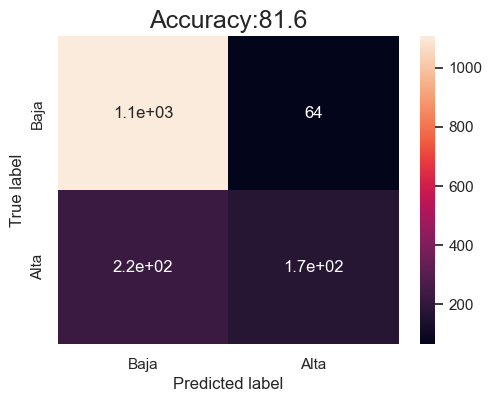

In [285]:
# Matriz de confusión
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred) * 100
# Visualización de la matriz de confusión
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy:{0:.1f}'.format(accuracy), size=18)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

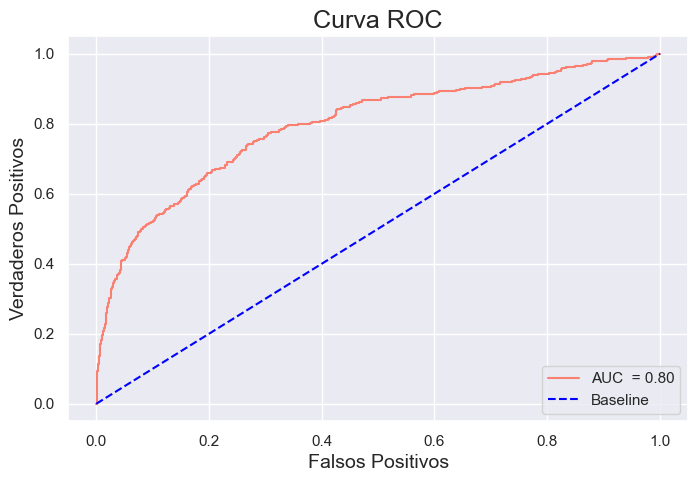

In [293]:
# Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = clf_lr_final.predict_proba(X_test_clf)[:, 1]

auc = metrics.roc_auc_score(y_test_clf, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_clf, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}', color='salmon')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=18)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend(loc='lower right')
plt.show()

#### Random Forest.

En segundo lugar, para la resolución del problema de regresión inicial convertido a problema de clasificación, se ha decidido utilizar este otro modelo. Para ello, se va a escalar los datos con *StandarScaler*. Por otro lado, para la búsqueda de hiperparámetros se va a utilizar la validación cruzada.

In [294]:
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()       # escalar
rf = RandomForestClassifier(random_state = 49)      # modelo

pipe_scale_rf = Pipeline([
    ('scale', scaler),
    ('rf', rf)])

In [295]:
param_grid = {'rf__n_estimators': [10, 20, 30, 40, 50],
              'rf__max_depth': [1, 10, 30, 50],
              'rf__min_samples_split': [2, 10, 20],
              'rf__min_samples_leaf': [1, 5, 10, 15, 20]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

#budget = 40
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_rf = GridSearchCV (estimator  = pipe_scale_rf,
                    param_grid = param_grid,
                    scoring='accuracy', #OJO!!! scoring=‘balanced_accuracy’
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(49)

clf_rf.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=49))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 10, 30, 50],
                         'rf__min_samples_leaf': [1, 5, 10, 15, 20],
                         'rf__min_samples_split': [2, 10, 20],
                         'rf__n_estimators': [10, 20, 30, 40, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [296]:
resultados = pd.DataFrame(clf_rf.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
89,10,1,20,50,0.877711,0.008935,0.934769,0.000788
88,10,1,20,40,0.876140,0.010021,0.936498,0.001607
122,10,15,2,30,0.875825,0.012335,0.902546,0.003129
127,10,15,10,30,0.875825,0.012335,0.902546,0.003129
132,10,15,20,30,0.875825,0.012335,0.902546,0.003129


In [297]:
clf_rf.best_params_, clf_rf.best_score_

({'rf__max_depth': 10,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 20,
  'rf__n_estimators': 50},
 0.8777108933662915)

In [298]:
modelo_rf = clf_rf.best_estimator_
print("Importances:", modelo_rf['rf'].feature_importances_)
print("Accuracy de test:", modelo_rf.score(X_test_clf, y_test_clf))

Importances: [0.01329899 0.01929313 0.00789978 0.06127002 0.01259275 0.01515528
 0.10162051 0.0493284  0.01268919 0.02369616 0.08577985 0.03996151
 0.03107942 0.01633547 0.0135414  0.15599341 0.07107473 0.01210577
 0.02573163 0.02790768 0.16216349 0.04148145]
Accuracy de test: 0.8813018506700702


In [300]:
y_test_pred = modelo_rf.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1171
           1       0.81      0.69      0.75       396

    accuracy                           0.88      1567
   macro avg       0.86      0.82      0.83      1567
weighted avg       0.88      0.88      0.88      1567



#### Conclusiones

El modelo en general obtiene un muy buen resultado, una precisión alta del 88%. Como se puede observar, las métricas de precisión, recall y f1–score de la clase 0 son más altas que para la clase 1 debido a la frecuencia de instancias de cada clase. Como hemos visto anteriormente, la distribución de los datos hace que se obtenga un mejor rendimiento en las predicciones para la clase de baja energía en comparación con la clase de alta energía.

### Desbalance.

Para desarrollar un modelo de clasificación efectivo, es importante ver si existe un desbalance de clase en nuestro conjunto de datos. Por lo que a continuación, vamos a estudiar la frecuencia de cada clase para ver si se trata de un problema de clasificación desbalanceado. En cuyo caso, se proporcionará una mejor solución.

In [306]:
# Conteo de clases
conteo_clases = df_clf['energy'].value_counts()
print("Conteo de clases:")
print(conteo_clases)


Conteo de clases:
energy
0    3561
1    1187
Name: count, dtype: int64


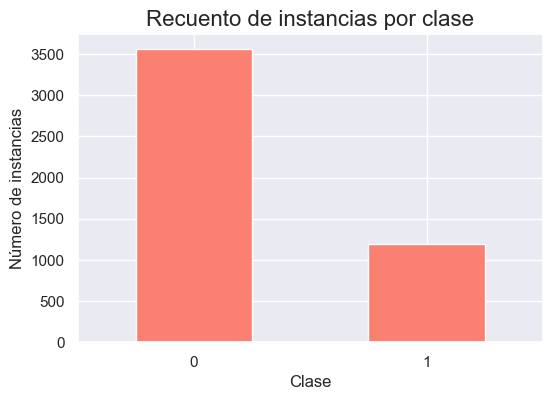

In [310]:
# Gráfico de barras
plt.figure(figsize=(6, 4))
conteo_clases.plot(kind='bar', color='salmon')
plt.title('Recuento de instancias por clase', size=16)
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.xticks(rotation=0)
plt.show()

#### Split estratificado

En primer lugar, se realiza este proceso para asegurarnos de que las proporciones de cada clase se mantenga en ambos conjuntos. Para conseguir una evaluación más precisa en nuestro problema desbalanceado.

In [311]:
# Dividimos los datos en entrenamiento y test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.33, random_state=49, stratify=y_clf)

#### Random Forest

El primer modelo que vamos a utilizar va a ser este. Utilizaremos búsqueda de hiperparámetros para ajusta el modelo de clasificación. Escalaremos los datos para obtener un mejor resultado. Y por último, para resolver el problema de desbalanceo, utilizaremos el parámetro `class_weight` igual a *balanced* para entrenar un conjunto de datos desbalanceado y como métrica *balanced accuracy*.

In [314]:
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()       # escalar
rf = RandomForestClassifier(random_state = 49, class_weight='balanced')      # modelo

pipe_scale_rf = Pipeline([
    ('scale', scaler),
    ('rf', rf)])

In [316]:
param_grid = {'rf__n_estimators': [1, 5, 10, 20, 30, 40, 50],
              'rf__max_depth': [1, 10, 30, 50],
              'rf__min_samples_split': [2, 3, 5, 10, 20],
              'rf__min_samples_leaf': [1, 5, 10, 15, 20]}

inner = KFold(n_splits=3, shuffle=True, random_state=49)

# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_rf_b = GridSearchCV(estimator  = pipe_scale_rf,
                    param_grid = param_grid,
                    scoring='balanced_accuracy',
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(49)

clf_rf_b.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=49))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 10, 30, 50],
                         'rf__min_samples_leaf': [1, 5, 10, 15, 20],
                         'rf__min_samples_split': [2, 3, 5, 10, 20],
                         'rf__n_estimators': [1, 5, 10, 20, 30, 40, 50]},
             return_train_score=True, scoring='balanced_accuracy', verbose=1)

In [317]:
clf_rf_b.best_params_, clf_rf_b.best_score_

({'rf__max_depth': 10,
  'rf__min_samples_leaf': 10,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 10},
 0.8389307361795225)

In [318]:
y_test_pred = clf_rf_b.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1175
           1       0.66      0.78      0.71       392

    accuracy                           0.84      1567
   macro avg       0.79      0.82      0.80      1567
weighted avg       0.86      0.84      0.85      1567



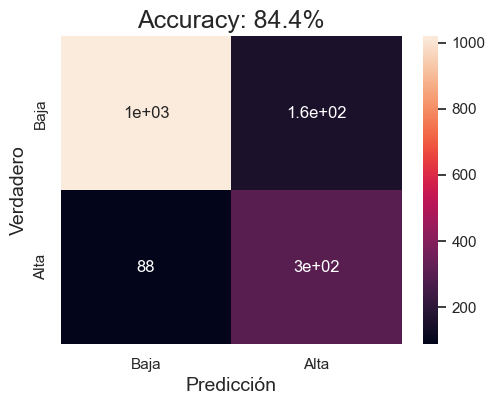

In [326]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred) * 100
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy: {0:.1f}%'.format(accuracy), size=18)
plt.ylabel('Verdadero', size=14)
plt.xlabel('Predicción', size=14)
plt.show()

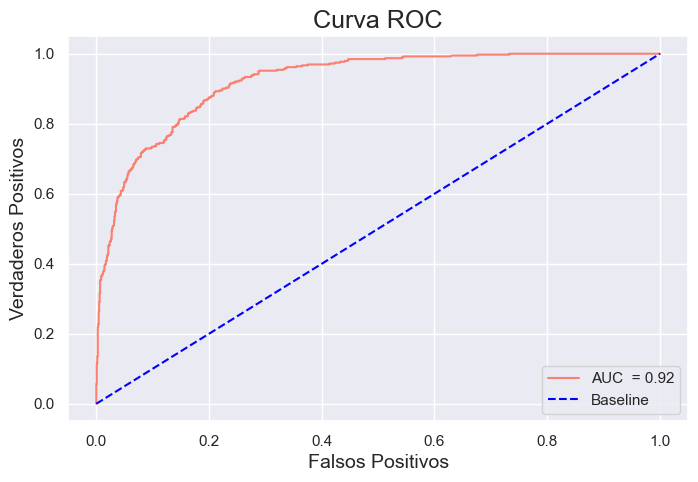

In [324]:
# Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = clf_rf_b.predict_proba(X_test_clf)[:, 1]

auc = metrics.roc_auc_score(y_test_clf, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_clf, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}', color='salmon')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=18)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend(loc='lower right')
plt.show()

Tras realizar este modelo se obtienen unos muy buenos resultados en la clasificación. Los resultados que se obtienen mejoran significativamente la clasificación y el inconveniente de desbalanceo que tenía inicialmente este problema de clasificación. Estos resultados nos indican que este modelo realiza eficazmente la identificación de las dos clases, pero aún así, se estudiarán otros modelos para ver si se puede mejorar el rendimiento.

#### HistGradientBoosting

In [328]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'max_depth'         : [None, 1, 3, 5, 10, 20, 30],
              'learning_rate'     : [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'l2_regularization' : [0, 1, 2],
              'max_leaf_nodes'    : [2, 3, 5, 10, 15],
              'min_samples_leaf'  : [10, 15, 20, 25, 30]
             }

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 100
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf_hgb = RandomizedSearchCV (estimator = HistGradientBoostingClassifier(
                                                class_weight='balanced',
                                                max_iter     = 1000,
                                                random_state        = 49,
                                                validation_fraction = 0.1,
                                                n_iter_no_change    = 5,
                                                tol                 = 0.0001),
                           param_distributions = param_grid,
                           scoring="balanced_accuracy",
                           cv=inner,
                           refit=True,
                           n_jobs=-1,
                           verbose=1,
                           n_iter=budget,
                           return_train_score=True)

np.random.seed(49)
clf_hgb.fit(X=X_train_clf, y=y_train_clf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                            max_iter=1000,
                                                            n_iter_no_change=5,
                                                            random_state=49,
                                                            tol=0.0001),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'l2_regularization': [0, 1, 2],
                                        'learning_rate': [0.001, 0.05, 0.01,
                                                          0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9],
                                        'max_depth': [None, 1, 3, 5, 10, 20,
                                                      30],
                                        'max_leaf_nodes': [2, 3, 5, 10, 15],
                                        'min_samples_leaf': [10, 15, 20, 25,
                                                             30]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=1)

In [329]:
# Mostrar los mejores parametros
clf_hgb.best_params_, clf_hgb.best_score_

({'min_samples_leaf': 30,
  'max_leaf_nodes': 2,
  'max_depth': 3,
  'learning_rate': 0.05,
  'l2_regularization': 0},
 0.8467117999752135)

In [330]:
y_test_pred = clf_hgb.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1175
           1       0.67      0.86      0.75       392

    accuracy                           0.86      1567
   macro avg       0.81      0.86      0.83      1567
weighted avg       0.88      0.86      0.86      1567



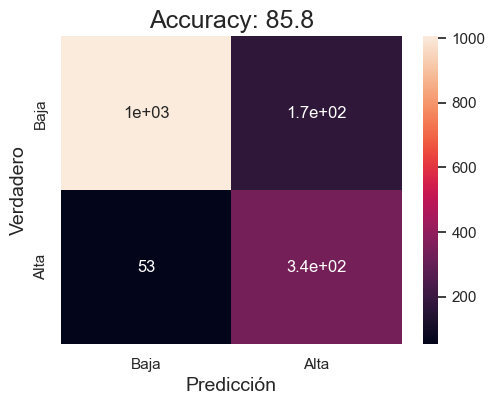

In [333]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred) * 100
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy: {0:.1f}'.format(accuracy), size=18)
plt.ylabel('Verdadero', size=14)
plt.xlabel('Predicción', size=14)
plt.show()

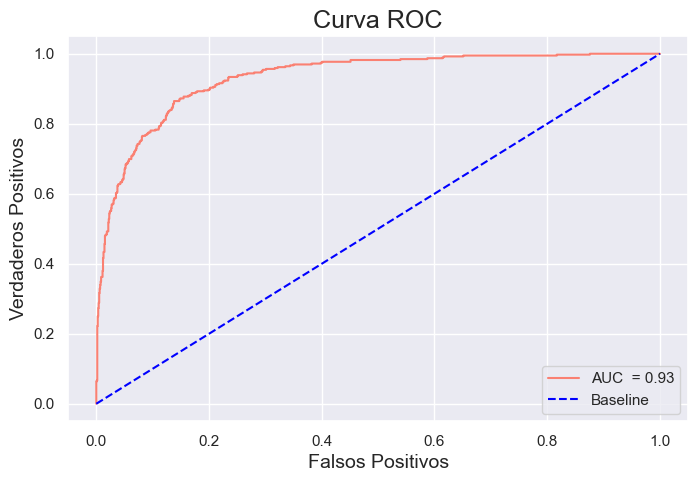

In [334]:
# Obtenemos las curva ROC y el área bajo la curva (AUC)
probs = clf_hgb.predict_proba(X_test_clf)[:, 1]

auc = metrics.roc_auc_score(y_test_clf, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_clf, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}', color='salmon')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=18)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend(loc='lower right')
plt.show()

Con este siguiente modelo hemos conseguido mejorar la precisión de nuestras predicciones comparadas con las obtenidas en el modelo anterior. Consiguiendo una precisión global del 86%, lo que significa que se consiguen identificar correctamente de media el 86% de veces. Por otro lado, se obtiene que el valor del área bajo la curva un valor del 0.93, lo que indica un muy buen rendimiento. Sin embargo, se puede observar que la precisión de la clase alta es 67%, mientras que la de la clase baja es de 86%, lo que deja todavía un breve margen de mejora.

#### XGBoost

Por útimo, finalizaremos realizando este modelo para ver si finalmente conseguimos un mejor resultado.

In [421]:
from xgboost import XGBClassifier

# espacio de búsqueda
param_grid = {'max_depth'        : [None, 1, 2, 3, 4, 5],
              'subsample'        : [0.5, 1, 2, 3, 4, 5],
              'learning_rate'    : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'n_estimators'     : sp_randint(50, 500)}

# Búsqueda por random search con validación cruzada
# ==============================================================================
inner = KFold(n_splits=3, shuffle=True, random_state=49)
budget = 400

clf_xgb = RandomizedSearchCV(
    estimator  = XGBClassifier(random_state = 49, scale_pos_weight = sum(y_train_clf==0)/sum(y_train_clf==1)),
    param_distributions= param_grid,
    scoring    = 'balanced_accuracy',
    n_jobs     = -1,
    cv         = inner,
    refit      = True,
    verbose    = 0,
    n_iter=budget
)

clf_xgb.fit(X = X_train_clf, y = y_train_clf)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=49, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=No...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=49, ...),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9],
                                        'max_depth': [None, 1, 2, 3, 4, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a8d366a0>,
                                        'subsample': [0.5, 1, 2, 3, 4, 5]},
                   scoring='balanced_accuracy')

In [422]:
# Mostrar los mejores parametros
clf_xgb.best_params_, clf_xgb.best_score_

({'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 399, 'subsample': 1},
 0.8491930505760591)

In [423]:
y_test_pred = clf_xgb.predict(X_test_clf)
result = metrics.classification_report(y_test_clf, y_test_pred)
print("Classification Report:",)
print (result)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1175
           1       0.69      0.83      0.75       392

    accuracy                           0.86      1567
   macro avg       0.81      0.85      0.83      1567
weighted avg       0.88      0.86      0.87      1567



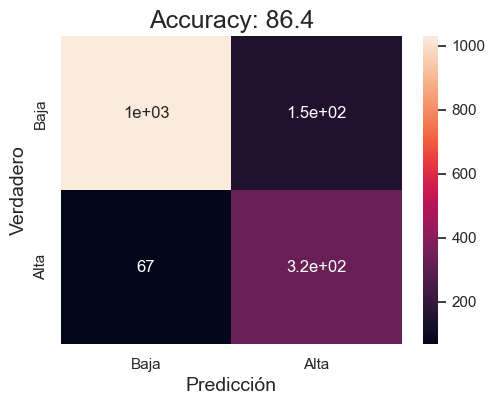

In [424]:
# Creates a confusion matrix
cm = metrics.confusion_matrix(y_test_clf, y_test_pred)
accuracy = metrics.accuracy_score(y_test_clf, y_test_pred) * 100
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Baja','Alta'],
                     columns = ['Baja','Alta'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Accuracy: {0:.1f}'.format(accuracy), size=18)
plt.ylabel('Verdadero', size=14)
plt.xlabel('Predicción', size=14)
plt.show()

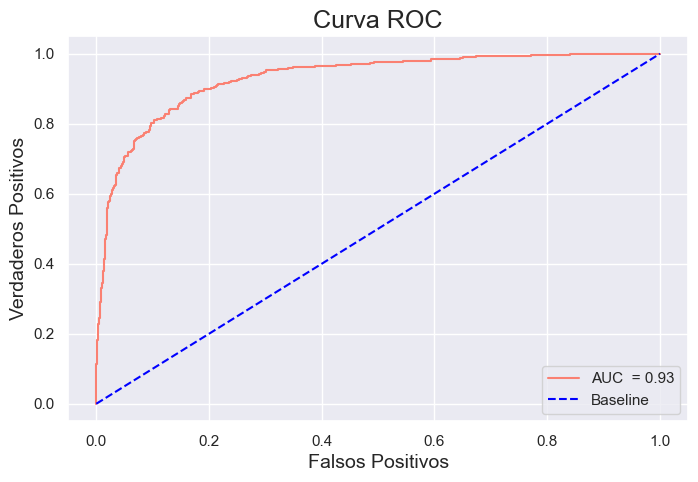

In [425]:
#Obtenemos las curva ROC y el área bajo la curva (AUC)

probs = clf_xgb.predict_proba(X_test_clf)[:, 1]

auc = metrics.roc_auc_score(y_test_clf, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test_clf, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}', color='salmon')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=18)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

Finalmente,este modelo ha logrado un muy buen rendimiento. Ha obtenido una precisión global del 86%. Además para la clase de baja energía, ha conseguido una precisión del 94%, mientras que para la otra clase, ha conseguido una precisión del 69%. Además, el valor obtenido por el AUC del 0.93, indica un muy buen rendimiento en la capacidad del modelo para identificar las clases. Por lo que estos resultados obtenidos indican que este modelo puede ser la opción adecuada para nuestro problema de clasificación.

---
## Chat GPT
---

Se ha utilizado la inteligencia artificial generativa, en momentos que no estabamos seguros de cómo realizar algunos procedimientos con Python. Es decir, para cosas muy concretas como el filtro de datos, la selección del tercer cuantil para las clases y para la depuración de errores. 